In [1]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import math
import random

In [2]:
# 根据依赖关系构建漏洞供应链
import igraph as ig
G = ig.Graph(directed=True)
with open('graph_supply_chain.csv', mode='r', newline='') as file:
    dependents_data = csv.DictReader(file)
    for row in dependents_data:
        up_name = row['up_name']
        down_name = row['down_name']
        # 检查节点是否存在，如果不存在则添加
        try:
            G.vs.find(name=up_name)
        except ValueError:
            G.add_vertex(name=up_name, cwe_ids=[])
        try:
            G.vs.find(name=down_name)
        except ValueError:
            G.add_vertex(name=down_name, cwe_ids=[])

        # 添加有向边
        G.add_edge(up_name, down_name)
        


# 创建一个字典以存储节点属性
node_attributes = {}

# 从文件中读取节点属性数据
with open('outdate_osv_cwe_ids.csv', mode='r', newline='') as file:
    cwe_data = csv.DictReader(file)
    for row in cwe_data:
        package_name = row['name']
        cwe_id = row['cwe_id']
        node = G.vs.find(name=package_name)
        if node:
            node['cwe_ids'].append(cwe_id)
            
for node, attributes in node_attributes.items():
    node_index = G.vs.find(name=node).index  # 获取节点的索引
    if 'package_name' in attributes:
        G.vs[node_index]['attributes'] = attributes
    else:
        print(f"Warning: Node '{node}' does not have 'package_name' attribute.")



In [4]:
# 使用 Louvain 算法进行社区检测，并传入分辨率参数
undirected_G = G.as_undirected()
best_partition = undirected_G.community_multilevel(resolution=0.0)

In [5]:
print(len(best_partition))

# 输出每个社区的 package_name 和 cwe_ids
for community_index, community in enumerate(best_partition):
    print(f"Community {community_index + 1}:")
    print(f"数量：{len(community)}")
    for node_index in community:
        node = G.vs[node_index]
        package_name = node['name']
        cwe_ids = node['cwe_ids']
        print(f"  Package Name: {package_name}")
        print(f"  CWE IDs: {', '.join(cwe_ids)}")
    print()

11
Community 1:
数量：446
  Package Name: @actions/core
  Package Name: set-env-action
  Package Name: web-whitelabel
  Package Name: china-dictatorship
  Package Name: @lob/lob-typescript-sdk
  Package Name: faunadb
  Package Name: @astranger1k/nuxt-hcaptcha
  Package Name: @mtt/next-auth
  Package Name: @sensoro/sensoro-design
  Package Name: ag-grid-autocomplete-editor
  Package Name: ag-grid-community
  Package Name: @uitoolkit/ui-components
  Package Name: @railmapgen/rmg-components
  Package Name: w-aggrid-vue
  Package Name: ag-grid-enterprise-free
  Package Name: icedfrisby-nock
  Package Name: gh-badges
  Package Name: is-svg
  Package Name: @rifcoin/toolkit
  Package Name: @taistudio/animeback-submit
  Package Name: react-oauth2-pkce-temp
  Package Name: xperts4all-react-oauth2-pkce
  Package Name: mithril
  Package Name: @isthmus/mithril
  Package Name: iso-app-renderer-mithril
  Package Name: mithril-jest
  Package Name: mithril-route-render
  Package Name: sin
  Package Name:

In [9]:
# 将每个社区所包含的包导出

# 创建一个列表以存储社区数据
community_data = []

for community_index, community in enumerate(best_partition):
    community_id = community_index + 1  # community_id
    for node_index in community:
        node = G.vs[node_index]
        package_name = node['name']
        community_data.append((community_id, package_name))

# 指定CSV文件的名称
csv_file_name = 'community_packages.csv'

# 将数据写入CSV文件
with open(csv_file_name, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(community_data)

print(f'数据已保存到 {csv_file_name}')

PermissionError: [Errno 13] Permission denied: 'community_packages.csv'

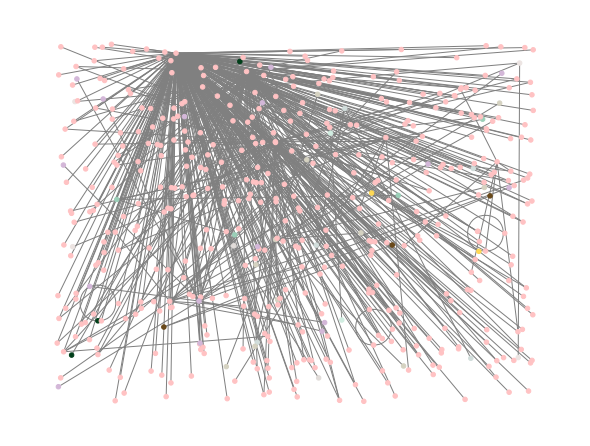

In [66]:
# 为每个社区分配一个颜色
colors = ['#ffc2c3', '#ffd954', '#9bcfb8', '#d1ede1','#d1dddb', '#e1dcd9','#d5d2c1','#69491a','#003e19'
          ,'#ece4e2', '#d3b7d8','#fe7773','#69491a','#7fb174','#283b42', '#072a24','#1d6a96','#e81e25'
         ]  

# 创建一个节点到颜色的映射字典
node_color_mapping = {}
for i, partition in enumerate(best_partition):
    color = colors[i % len(colors)]  # 循环使用颜色列表
    for node in partition:
        node_color_mapping[node] = color

        
# 转换为 NetworkX 图
nx_G = nx.Graph(G.get_edgelist())

# 提取节点颜色
node_colors = [node_color_mapping[node] for node in nx_G.nodes]

# 使用 NetworkX 布局
# pos = nx.spring_layout(nx_G,center=(0.5, 0.5), scale=1.0, k = 0.08)
pos = nx.kamada_kawai_layout(nx_G,scale = 0.01)
# pos = nx.random_layout(nx_G)

node_colors = [node_color_mapping[node] for node in nx_G.nodes]
edge_colors = ['grey' if nx_G.has_edge(u, v) else 'black' for u, v in nx_G.edges]

# 绘制图形
plt.figure(figsize=(8, 6))
nx.draw(nx_G, pos, with_labels=False, node_color=node_colors, node_size=20, edge_color = edge_colors)
savefig_path = './'
# plt.savefig(savefig_path + 'sc_community.png', format='png', dpi=200)
plt.show()